In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import implicit  # https://github.com/benfred/implicit
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import bm25_weight

import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.sparse import coo_matrix

import dask
from dask.diagnostics import ProgressBar

import tqdm
import codecs

# Load data

In [2]:
train_data = pd.read_csv('./output/train_data_full.csv')

In [3]:
assert(len(train_data) == 7964397)

In [4]:
train_data.dtypes

session_start_datetime     object
user_id                     int64
user_ip                     int64
primary_video_id            int64
video_id                    int64
vod_type                   object
session_duration            int64
device_type                object
device_os                  object
player_position_min         int64
player_position_max         int64
time_cumsum_max             int64
video_duration              int64
watching_percentage       float64
dtype: object

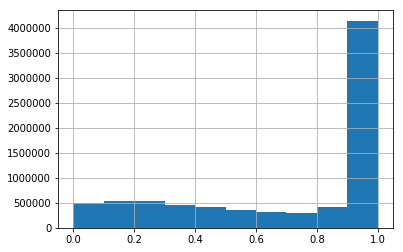

In [5]:
train_data['watching_percentage'].hist()

## ALS Implicit

https://github.com/benfred/implicit

### transform

In [6]:
video_id_le = preprocessing.LabelEncoder()
video_id_le.fit(train_data.primary_video_id)
video_id_le.classes_

array([    4442,     7360,     9559, ..., 33540856, 33547468, 33553858])

In [7]:
train_data['primary_video_id_encoded'] = video_id_le.transform(train_data.primary_video_id)

In [8]:
user_id_le = preprocessing.LabelEncoder()
user_id_le.fit(train_data.user_id)
user_id_le.classes_

array([      204,       368,       613, ..., 134215575, 134215993,
       134217335])

In [9]:
train_data['user_id_encoded'] = user_id_le.transform(train_data.user_id)

In [10]:
train_data_matrix = coo_matrix(
    (train_data.watching_percentage, (train_data.user_id_encoded, train_data.primary_video_id_encoded)),
    shape=(train_data.user_id_encoded.max()+1, train_data.primary_video_id_encoded.max()+1),
    dtype=np.float32).tocsr()
train_data_matrix  # users-items

<402009x7221 sparse matrix of type '<class 'numpy.float32'>'
	with 4162327 stored elements in Compressed Sparse Row format>

In [11]:
weighted_train_data_matrix = bm25_weight(train_data_matrix, B=0.7).tocsr() * 5
weighted_train_data_matrix.data[:10]

array([67.63284788, 40.93788386, 69.07483483, 44.73216062, 46.94768734,
       34.10793002, 69.82786894,  2.86816791, 25.51397712, 43.50773169])

### train

In [12]:
model = AlternatingLeastSquares(factors=70, regularization=0.01, iterations=15,
                                calculate_training_loss=True)
model.fit(weighted_train_data_matrix.T)  # items-users

100%|██████████| 15.0/15 [00:48<00:00,  2.75s/it, loss=0.0122]


In [13]:
# model = BayesianPersonalizedRanking(factors=100, regularization=0.01, iterations=15)
# model.fit(train_data_matrix.T)  # items-users

### predict

In [14]:
def pred_fn(model, video_id_le, user_id, mat, qty):
    return user_id, video_id_le.inverse_transform([r[0] for r in model.recommend(user_id, mat, qty)])

In [15]:
users_encoded_list = range(train_data.user_id_encoded.max()+1)
delayed_results = []

with tqdm.tqdm(total=len(users_encoded_list)) as progress:
    for encoded_user_id in users_encoded_list:
        delayed_results.append(
            dask.delayed(pred_fn)(model, video_id_le, encoded_user_id, weighted_train_data_matrix, 10))
        progress.update(1)

100%|██████████| 402009/402009 [00:29<00:00, 13597.52it/s]


In [16]:
with ProgressBar():
    predicted_results = dask.compute(*delayed_results)

[########################################] | 100% Completed |  7min 44.7s


In [17]:
predicted_df = pd.DataFrame({
    'user_id': user_id_le.inverse_transform([r[0] for r in predicted_results]),
    'predicted_primary_video_id': [r[1] for r in predicted_results]
}, columns=['user_id', 'predicted_primary_video_id'])

In [18]:
predicted_df[:10]

,user_id,predicted_primary_video_id
0,204,"[13619739, 24781930, 15227534, 24291250, 16646..."
1,368,"[30566249, 12570234, 13378235, 14143501, 21308..."
2,613,"[7801099, 11536584, 26455666, 13646802, 292460..."
3,1325,"[30986288, 19624341, 5159408, 29646969, 112698..."
4,1410,"[30986288, 22045752, 29276476, 22777163, 26183..."
5,1894,"[11937693, 19624341, 32222690, 3696413, 958364..."
6,2026,"[22773719, 18065882, 30714570, 11653814, 19156..."
7,2369,"[25075677, 2968691, 16088655, 25004533, 116391..."
8,2737,"[27946137, 10979465, 16056034, 6538348, 272973..."
9,2745,"[22526874, 6597685, 20236783, 6946785, 2175733..."


### save

In [19]:
sample_submission = pd.read_csv('./output/sample_submission_full.csv')
sample_submission = sample_submission.join(predicted_df.set_index('user_id'), 'user_id')
sample_submission[:10]

,user_id,primary_video_id,predicted_primary_video_id
0,1088,25397362 20236783 24633210 2677761 31588514 22...,NaN
1,28577,25397362 20236783 24633210 2677761 31588514 22...,"[22575620, 5760990, 29718043, 33252778, 183690..."
2,188122,25397362 20236783 24633210 2677761 31588514 22...,"[27740348, 26997030, 14414023, 29010961, 48740..."
3,235599,25397362 20236783 24633210 2677761 31588514 22...,"[6597685, 21757334, 17487453, 33501500, 279811..."
4,274770,25397362 20236783 24633210 2677761 31588514 22...,"[27946137, 16056034, 31382698, 28776964, 25656..."
5,554364,25397362 20236783 24633210 2677761 31588514 22...,"[10735044, 25146623, 14414023, 723695, 1449652..."
6,564435,25397362 20236783 24633210 2677761 31588514 22...,"[192557, 4460659, 12153123, 30291128, 18298571..."
7,946127,25397362 20236783 24633210 2677761 31588514 22...,"[31148166, 21426834, 11653814, 29718043, 23786..."
8,955946,25397362 20236783 24633210 2677761 31588514 22...,"[23987196, 22439208, 22126352, 1958224, 305458..."
9,1223195,25397362 20236783 24633210 2677761 31588514 22...,"[5794535, 5760990, 3781036, 33252778, 29957220..."


In [20]:
sample_submission['primary_video_id'] = sample_submission.predicted_primary_video_id.combine_first(
    sample_submission.primary_video_id)
del sample_submission['predicted_primary_video_id']

In [ ]:
sample_submission.to_csv('./output/sample_submission_full_implicit_als.csv.gz',
                         header=True, index=False, compression='gzip')